In [3]:
%load_ext autoreload
%autoreload 2
from lib.ekyn import *
from sklearn.model_selection import train_test_split
from torch import bincount
from lib.utils import plot_eeg_and_labels
from lib.models import MLP
from tqdm import tqdm
from torch import optim
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import numpy as np
import random
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report
from lib.env import DEVICE
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
from lib.utils import Windowset
from torch.nn.functional import relu
import json
from lib.models import ResNetv3

PROJECT_DIR = f'../projects/balanced_w1_b3_s16'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)
train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
trainloader = DataLoader(Windowset(*load_eeg_label_pairs(ids=train_idx),CONFIG['WINDOW_SIZE']),batch_size=CONFIG['BATCH_SIZE'],shuffle=True)
devloader = DataLoader(Windowset(*load_eeg_label_pairs(ids=test_idx),CONFIG['WINDOW_SIZE']),batch_size=CONFIG['BATCH_SIZE'],shuffle=False)

model = ResNetv3(windowsize=CONFIG['WINDOW_SIZE'],starting_filters=CONFIG['STARTING_FILTERS'],n_blocks=CONFIG['N_BLOCKS'])
criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716])).to(DEVICE)
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<All keys matched successfully>

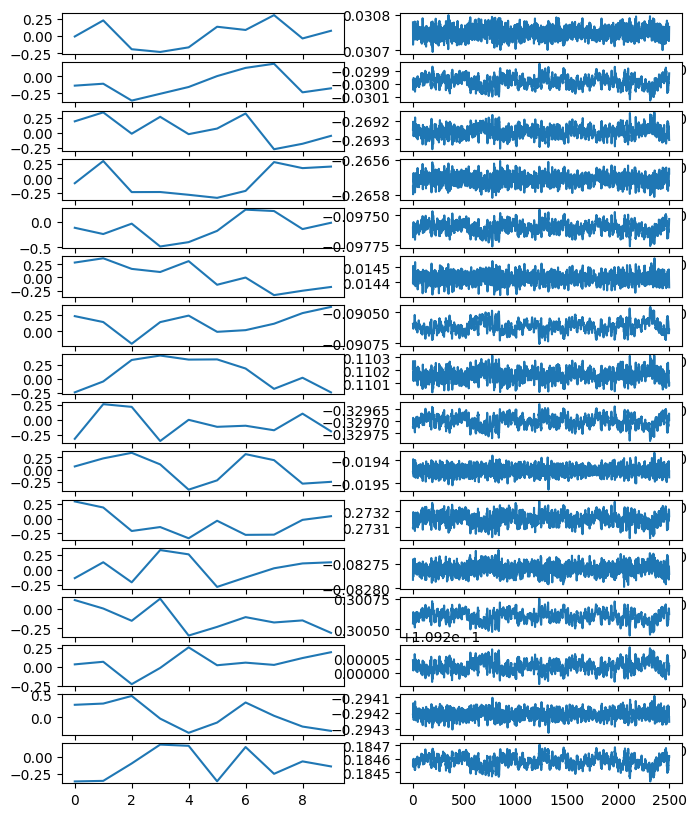

In [4]:
model.to('cpu')
Xi,yi = next(iter(devloader))

fig,ax = plt.subplots(nrows=len(model.c1.weight),ncols=2,figsize=(8,10))
for i,kernel in enumerate(model.c1.weight.squeeze().detach()):
    ax[i,0].plot(kernel)
for i,kernel in enumerate(model.c1(Xi.reshape(-1,1,5000)).detach()[0]):
    ax[i,1].plot(kernel)

100%|██████████| 135/135 [00:06<00:00, 19.88it/s]


              precision    recall  f1-score   support

         0.0       0.60      0.74      0.66      3504
         1.0       0.93      0.94      0.93     31617
         2.0       0.92      0.89      0.91     33999

    accuracy                           0.90     69120
   macro avg       0.82      0.86      0.83     69120
weighted avg       0.91      0.90      0.91     69120

1.1892535896212966


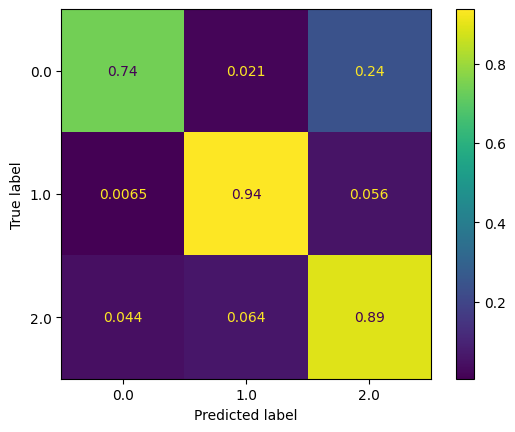

In [5]:
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

torch.Size([17280, 5000]) torch.Size([17280, 3])
tensor([ 943, 7976, 8361])


100%|██████████| 34/34 [00:01<00:00, 28.78it/s]


              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72       943
         1.0       0.94      0.96      0.95      7976
         2.0       0.95      0.90      0.92      8361

    accuracy                           0.92     17280
   macro avg       0.85      0.89      0.87     17280
weighted avg       0.93      0.92      0.92     17280

0.9618032697369071


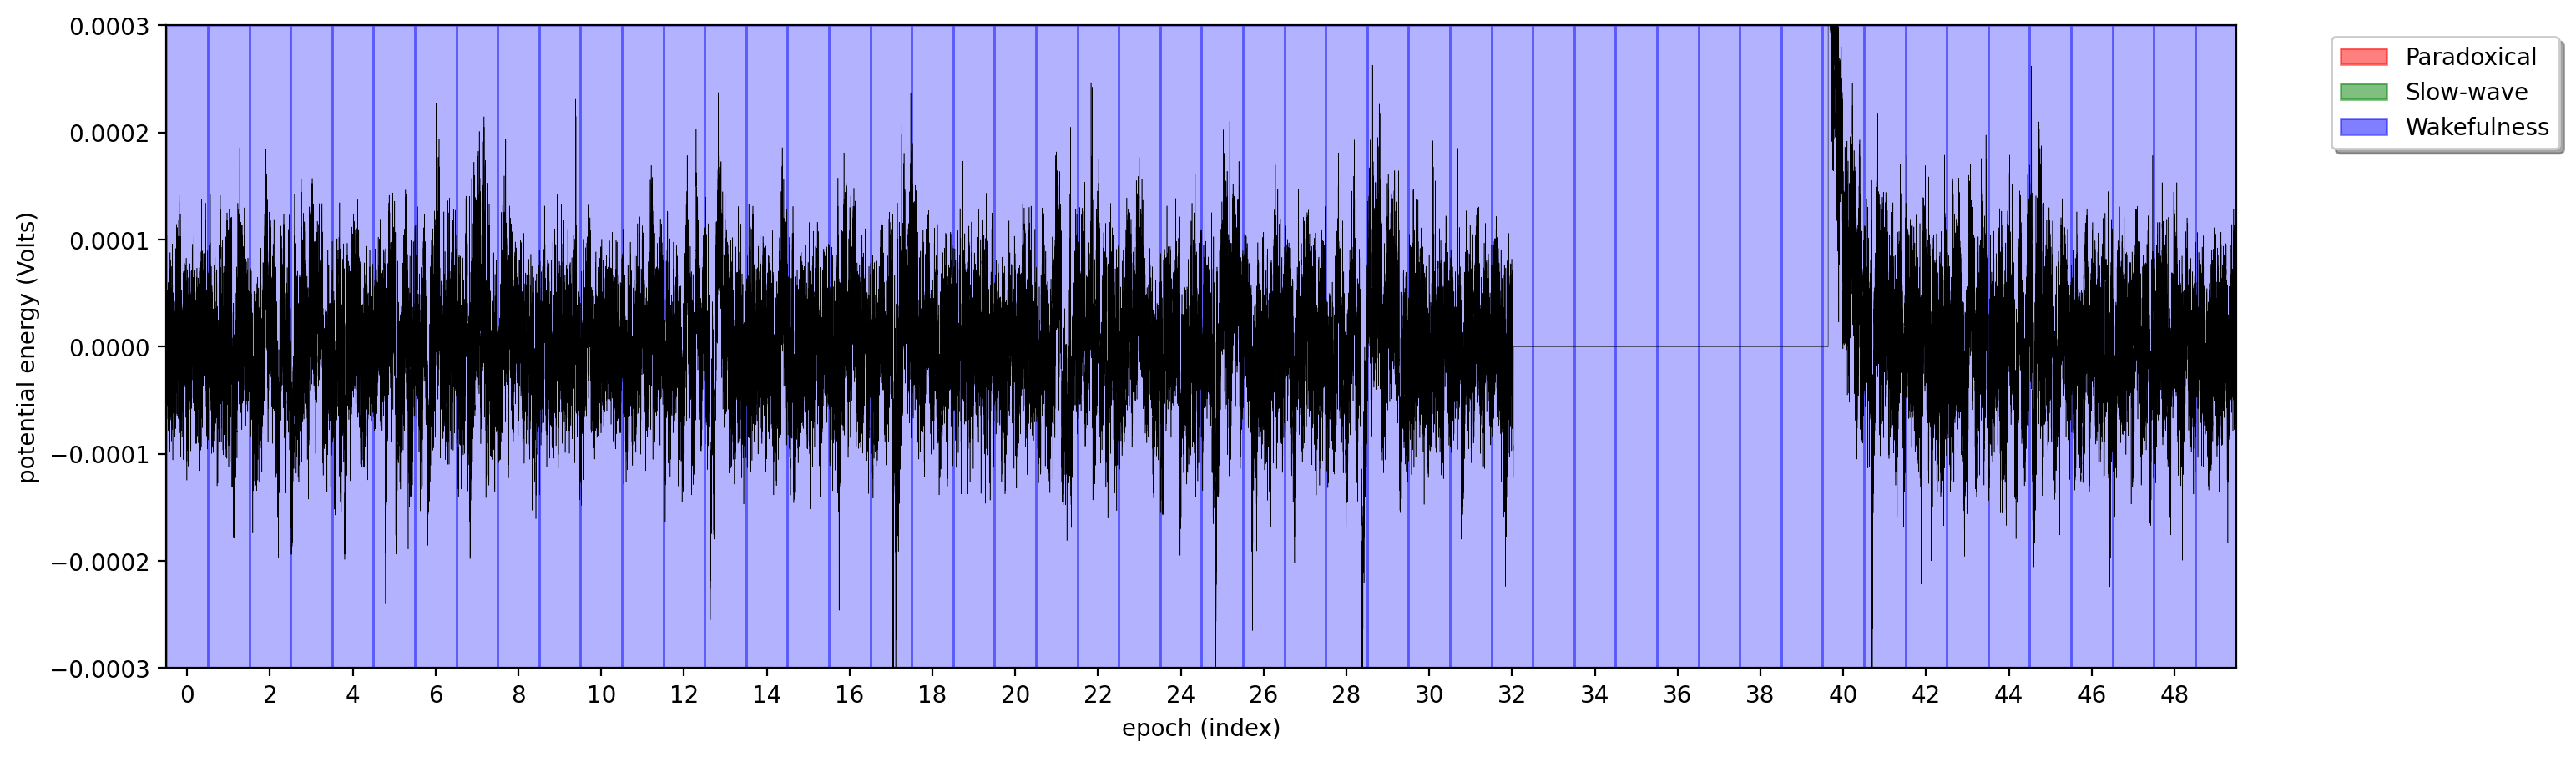

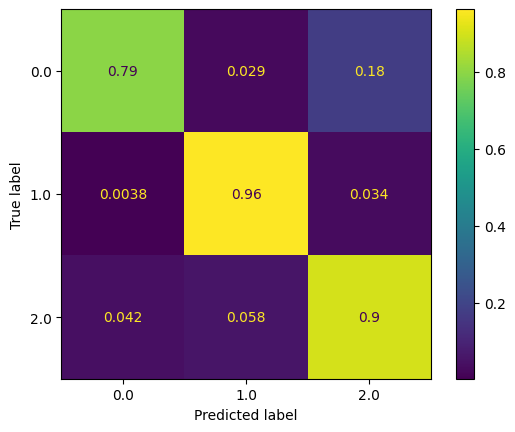

In [6]:
from torch.utils.data import TensorDataset

X,y = load_eeg_label_pairs(ids=test_idx[:1])
print(X.shape,y.shape)
print(bincount(y.argmax(axis=1)))
plot_eeg_and_labels(X,y.argmax(axis=1),start=0,duration=50)
testloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=False)
import matplotlib.pyplot as plt
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=testloader,model=model,criterion=criterion,DEVICE=DEVICE)
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

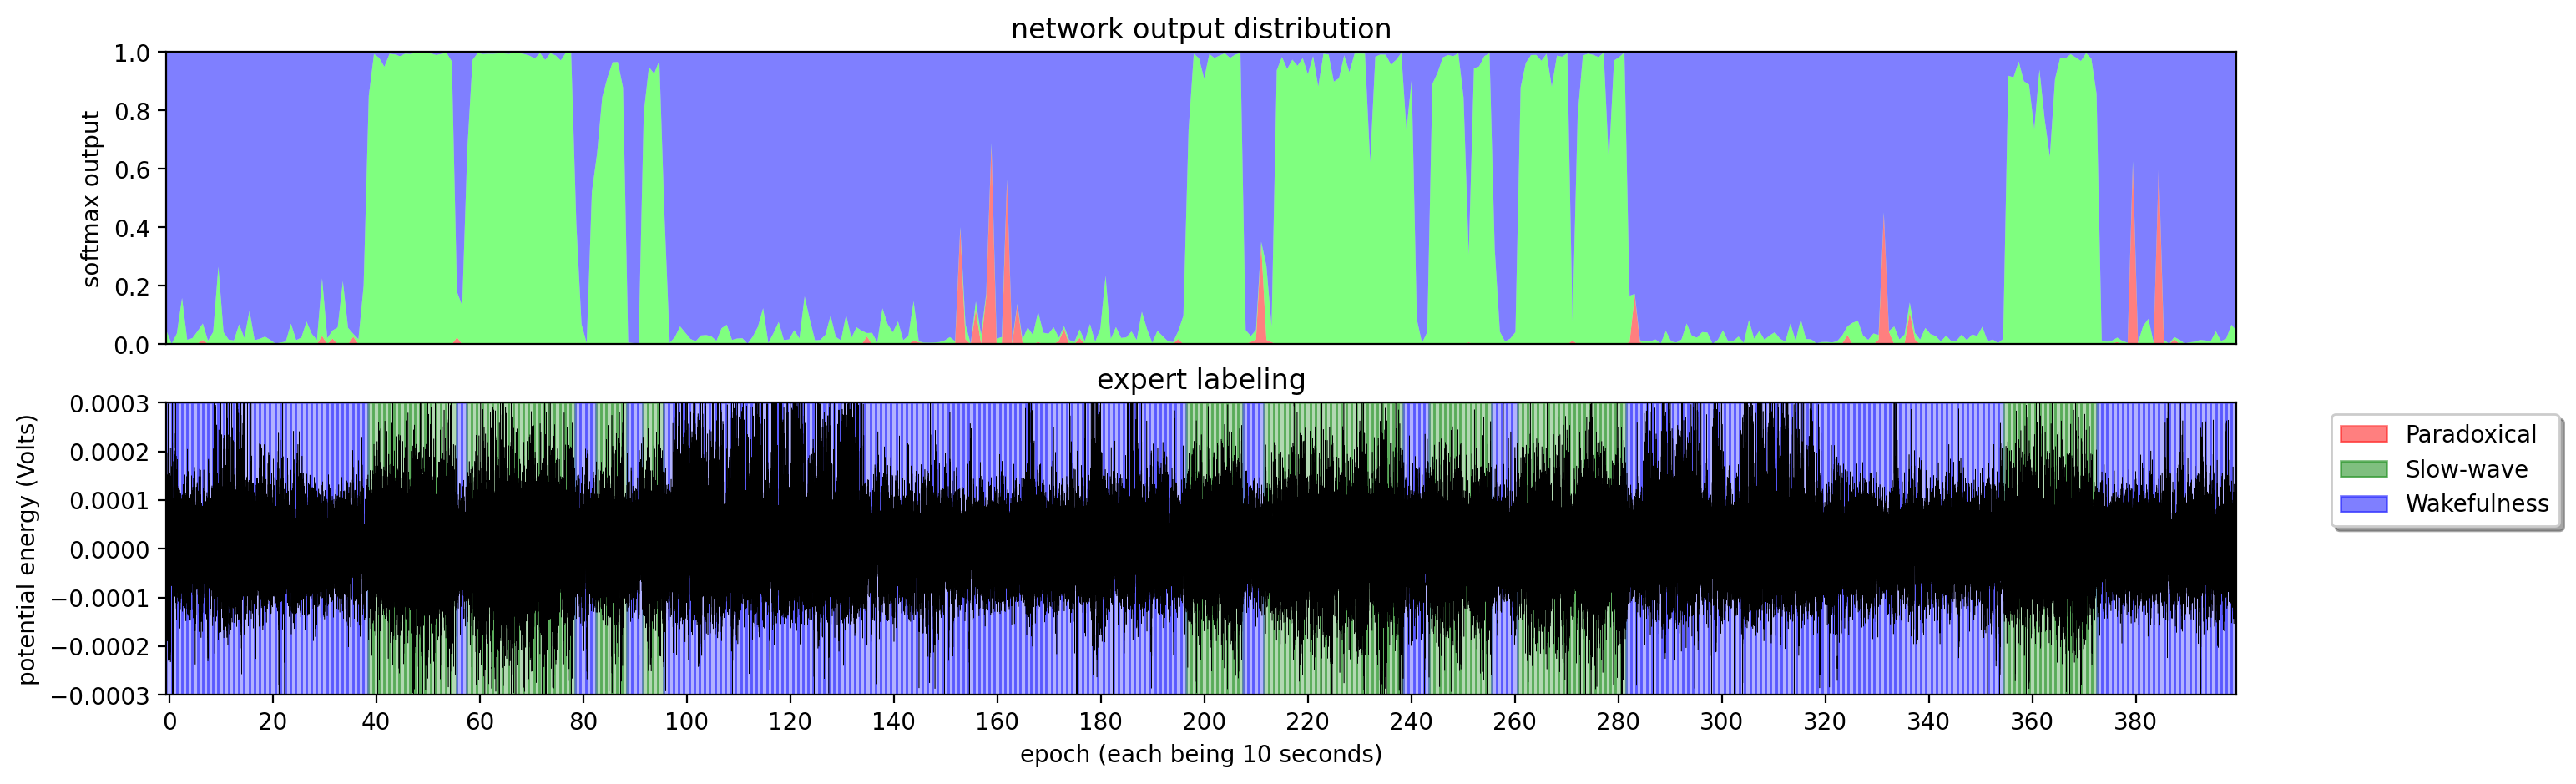

In [11]:
import matplotlib.patches as patches
start = 2500
duration = 400
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,5),dpi=200)

ax[1].plot(X[start:start+duration].flatten(),'black',linewidth=.2)
colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[1].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
ax[1].set_ylim([-.0003,.0003])
ax[1].margins(0,0)
plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
        fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (each being 10 seconds)')
ax[1].set_ylabel('potential energy (Volts)')
ax[1].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);

ax[0].stackplot(torch.linspace(0,duration-1,duration),y_logits[start:start+duration,0],y_logits[start:start+duration,1],y_logits[start:start+duration,2],colors=['#FF000080','#00FF0080','#0000FF80'])
ax[0].margins(0,0)
ax[0].set_xticks([])
ax[0].set_title('network output distribution')
ax[0].set_ylabel('softmax output')
ax[1].set_title('expert labeling')
plt.savefig('Sleep3.jpg',bbox_inches='tight')

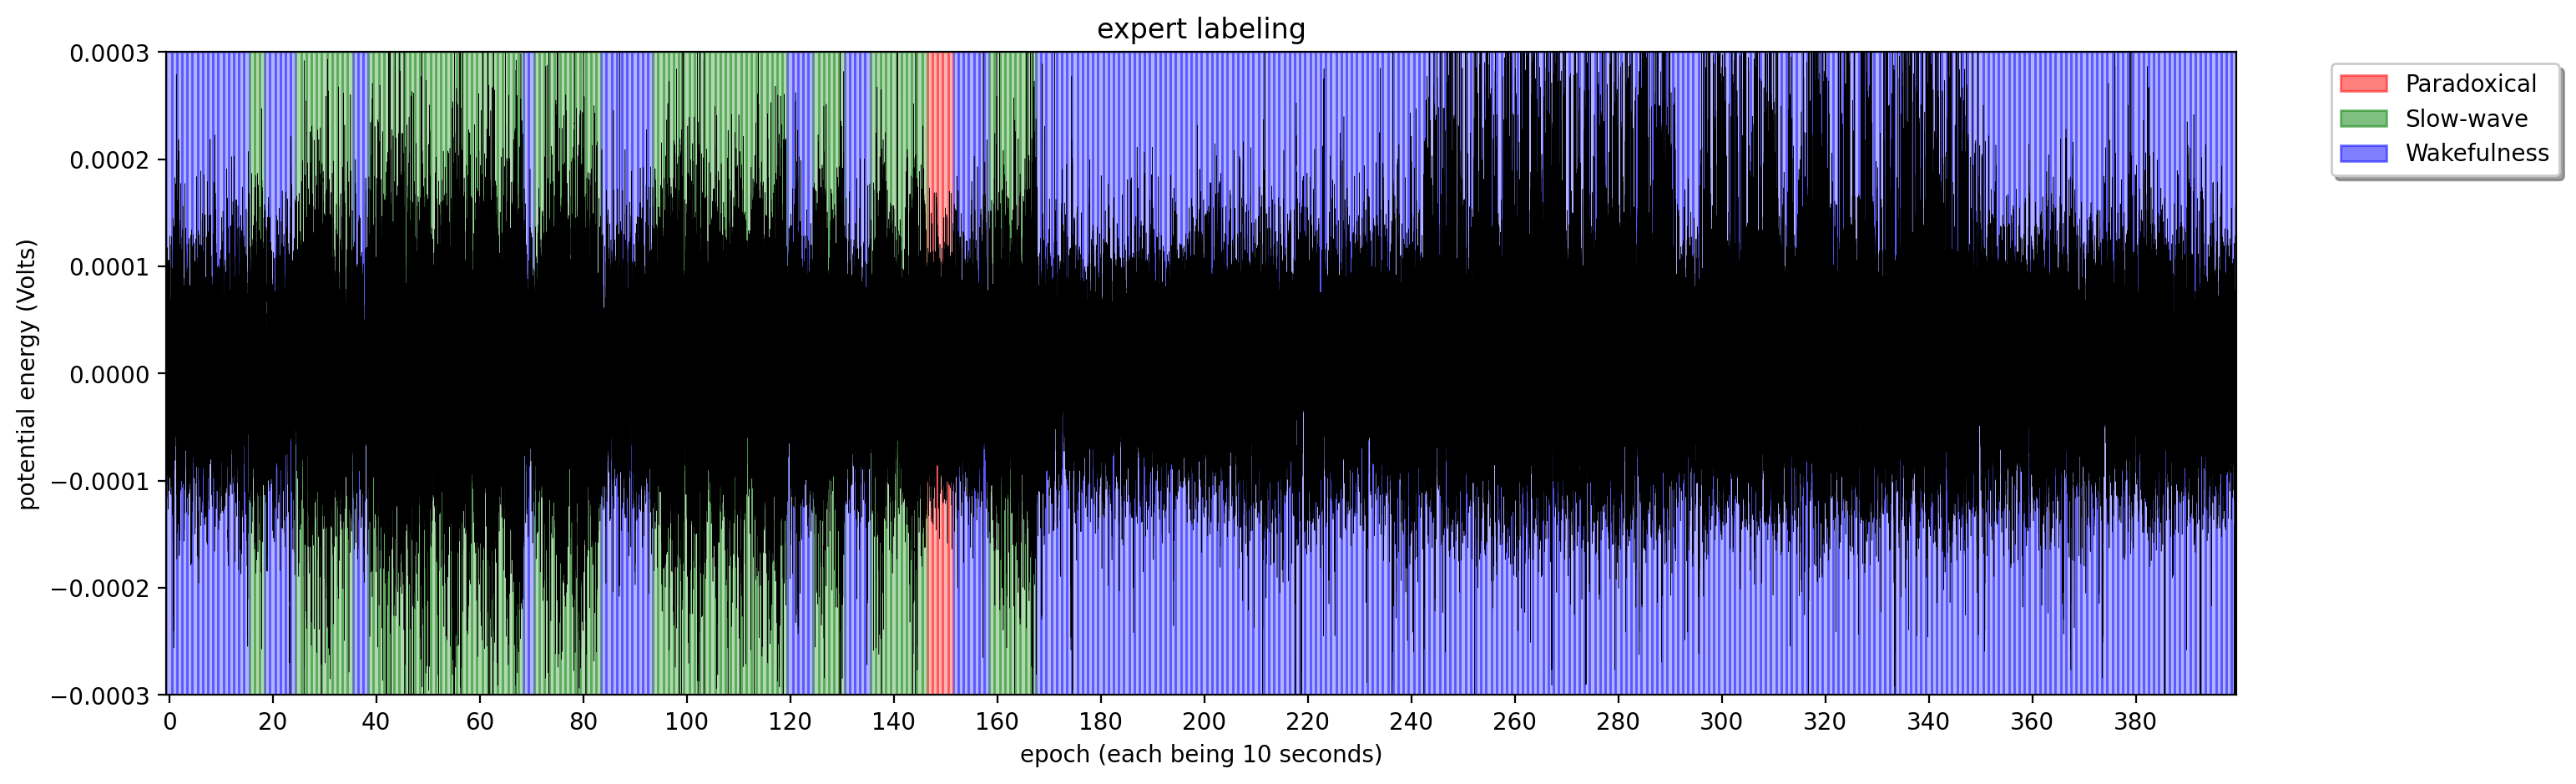

In [14]:
import matplotlib.patches as patches
start = 3000
duration = 400
plt.figure(figsize=(16,5),dpi=200)

plt.plot(X[start:start+duration].flatten(),'black',linewidth=.2)
colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    plt.fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
plt.ylim([-.0003,.0003])
plt.margins(0,0)
plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
        fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (each being 10 seconds)')
plt.ylabel('potential energy (Volts)')
plt.xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);

plt.title('expert labeling')
plt.savefig('Sleep4.jpg',bbox_inches='tight')

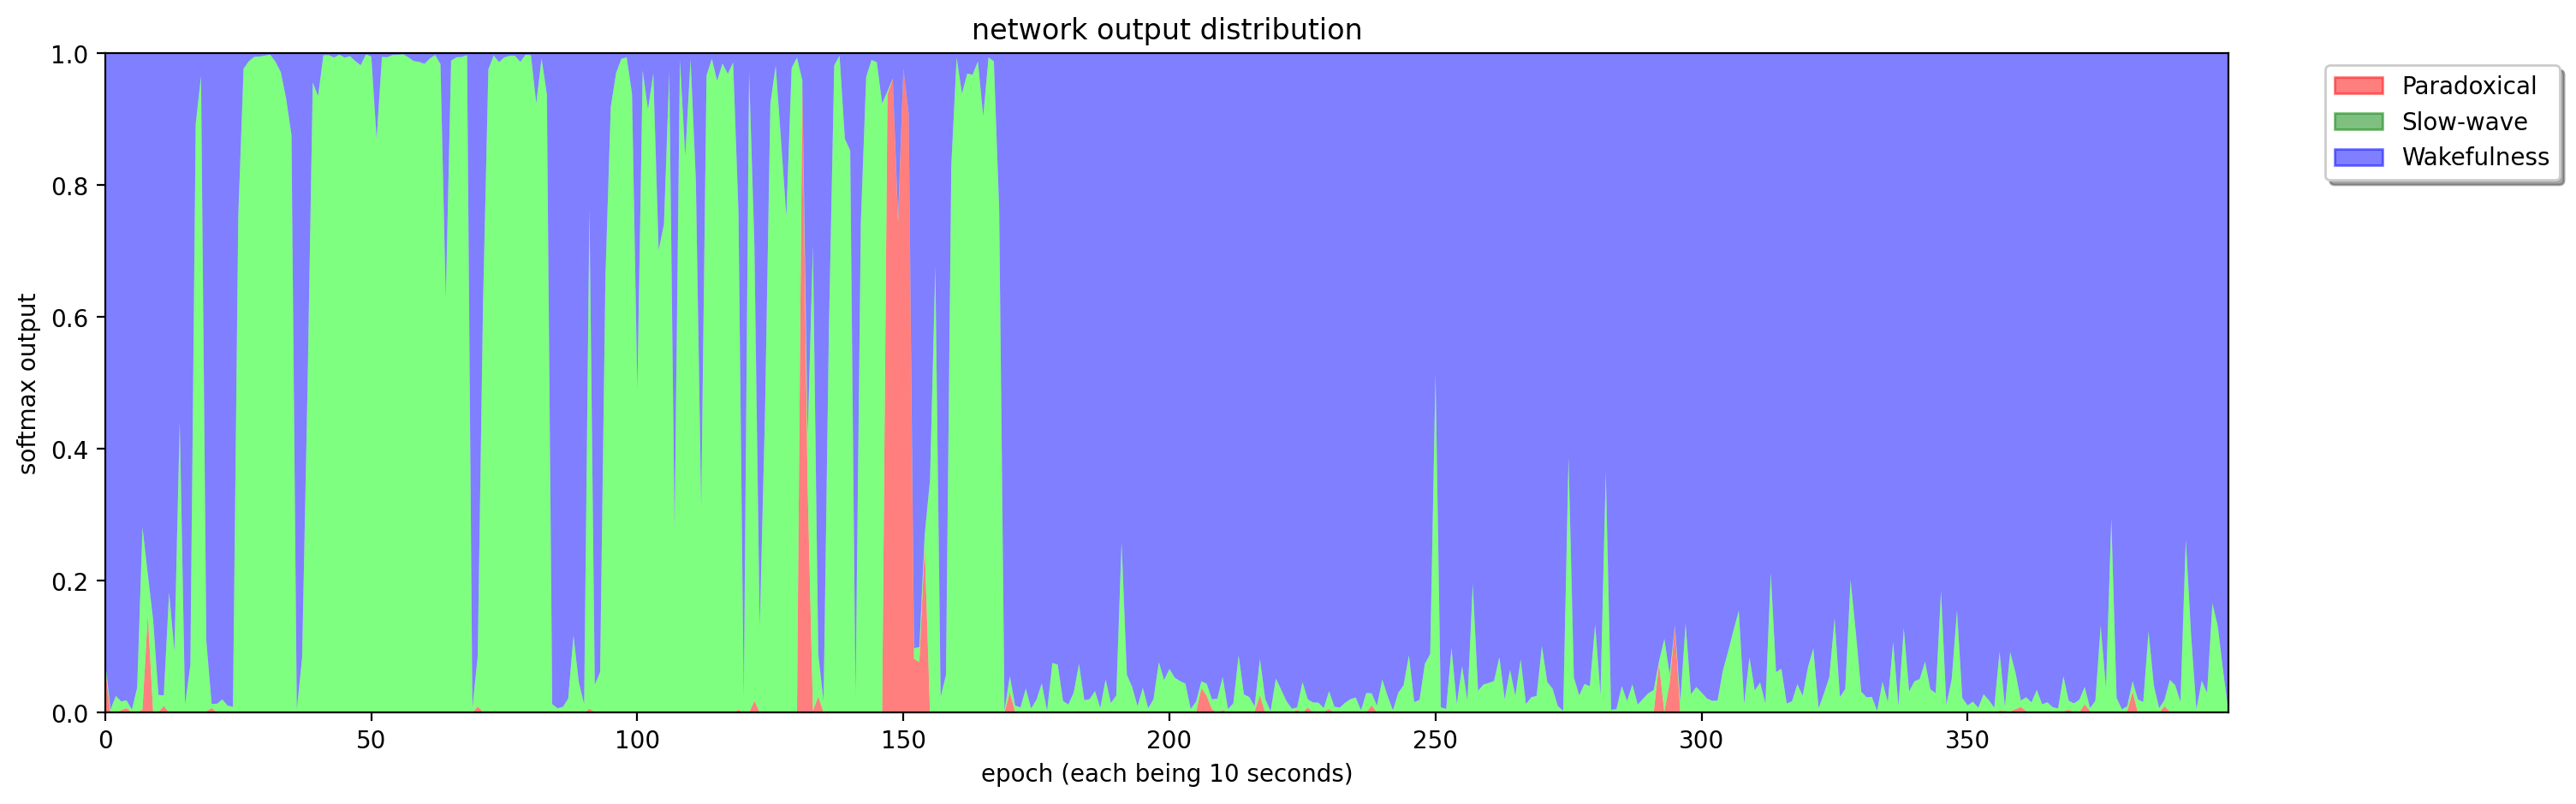

In [18]:
import matplotlib.patches as patches
start = 3000
duration = 400
plt.figure(figsize=(16,5),dpi=200)

colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    epochs.append(i*5000+2500)

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
        fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (each being 10 seconds)')

plt.stackplot(torch.linspace(0,duration-1,duration),y_logits[start:start+duration,0],y_logits[start:start+duration,1],y_logits[start:start+duration,2],colors=['#FF000080','#00FF0080','#0000FF80'])
plt.margins(0,0)
plt.title('network output distribution')
plt.ylabel('softmax output')
plt.savefig('Sleep5.jpg',bbox_inches='tight')